In [ ]:
python train.py --model_path out/rwkv1b5-v060_pretrain/rwkv-8.pth \
    
    --lr_init 3e-5 --lr_final 1.5e-5 --warmup_steps 0 --beta1 0.9 --beta2 0.99 --adam_eps 1e-8 \
    --accelerator gpu --devices 8 --precision bf16 --strategy deepspeed_stage_1 --grad_cp 1 \
    --image_folder /houhaowenT/huggingface_datasets/LLaVA-Instruct-150K/images/ \
    --vision_tower_name /houhaowenT/huggingface_models/openai/clip-vit-large-patch14-336 \
    --freeze_rwkv 0 --freeze_proj 0 --detail low --grid_size -1 --image_position middle \
    --enable_progress_bar True

/tmp/ipykernel_6237/1388653859.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  msg = model.load_state_dict(torch.load(args.model_path, map_location=device), strict=Fals

RGB


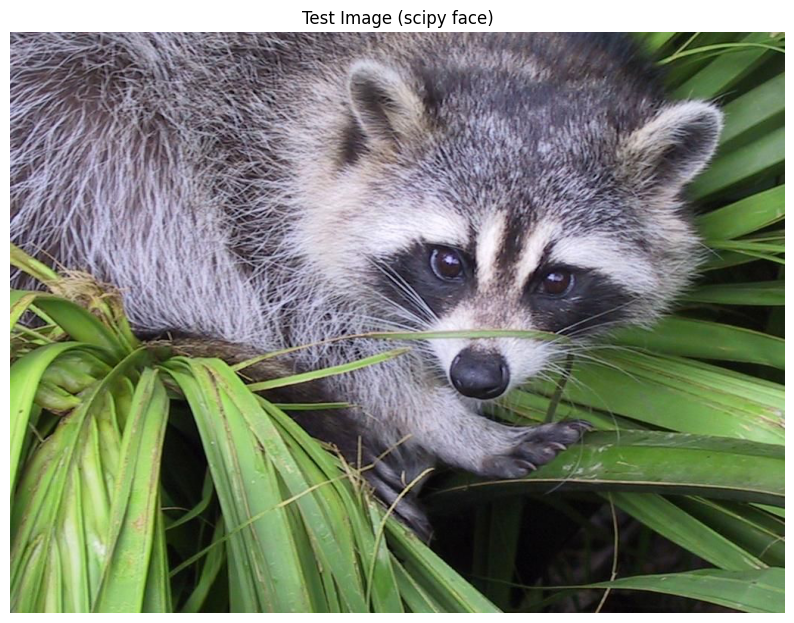

Input Query: What do you see in this image? Describe it in detail.


RuntimeError: expected scalar type BFloat16 but found Half

In [3]:
import os
os.environ["RWKV_JIT_ON"] = "1"
current_path = os.environ.get('LD_LIBRARY_PATH', '')
os.environ['LD_LIBRARY_PATH'] = '/usr/lib/x86_64-linux-gnu:' + current_path

import torch
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from transformers import AutoImageProcessor
from src.rwkv_tokenizer import TRIE_TOKENIZER
from src.dataset import DEFAULT_IMAGE_TOKEN, DEFAULT_STOP_TOKEN, STOP_TOKEN_INDEX
from src.dataset import process_image_tokens_in_conversations, preprocess
from src.utils import Conversation
from scipy import misc
import warnings, datetime
from pytorch_lightning import seed_everything

# Args 설정
class Args:
    def __init__(self):
        # 모델 기본 설정
        self.load_model = ""
        self.vocab_size = 65536
        self.ctx_len = 2048
        self.n_layer = 24
        self.n_embd = 2048
        self.dim_att = 0  # n_embd와 동일하게 설정
        self.dim_ffn = 0  # n_embd * 3.5 (rounded to multiple of 32)
        self.pre_ffn = 0
        self.head_size_a = 64
        self.head_size_divisor = 8
        self.dropout = 0
        self.grad_cp = 0
        self.freeze_rwkv = 1
        self.freeze_proj = 1
        self.precision = "bf16"
        self.model_path = "./model/VisualRWKV_baseline_1b6.pth"

        
        # 비전 모델 설정
        self.vision_tower_name = "/home/gpuadmin/Desktop/RWKV/myclip"
        self.load_model = ""
        self.grid_size = 8
        self.detail = "low"
        self.image_position = "middle"

        self.random_seed = -1
        self.device = "cuda" if torch.cuda.is_available() else "cpu"


args = Args()
device = "cuda" if torch.cuda.is_available() else "cpu"

if args.random_seed >= 0:
    print(f"########## WARNING: GLOBAL SEED {args.random_seed} THIS WILL AFFECT MULTIGPU SAMPLING ##########\n" * 3)
    seed_everything(args.random_seed)

np.set_printoptions(precision=4, suppress=True, linewidth=200)
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
warnings.filterwarnings("ignore", ".*The progress bar already tracks a metric with the*")

args.my_timestamp = datetime.datetime.today().strftime("%Y-%m-%d-%H-%M-%S")
args.enable_checkpointing = False
args.replace_sampler_ddp = False
args.logger = False
os.environ["RWKV_CTXLEN"] = str(args.ctx_len)
os.environ["RWKV_HEAD_SIZE_A"] = str(args.head_size_a)
if args.dim_att <= 0:
    args.dim_att = args.n_embd
if args.dim_ffn <= 0:
    args.dim_ffn = int((args.n_embd * 3.5) // 32 * 32) # default = 3.5x emb size

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.matmul.allow_tf32 = True

from src.model import VisualRWKV
# 모델, 토크나이저, 이미지 프로세서 초기화
model = VisualRWKV(args).half().to(device)
if args.model_path:
    msg = model.load_state_dict(torch.load(args.model_path, map_location=device), strict=False)
if args.freeze_rwkv>0:
    model.freeze_rwkv(args.freeze_rwkv)
if args.freeze_proj>0:
    model.freeze_proj()
model.freeze_emb()

tokenizer = TRIE_TOKENIZER("./src/rwkv_vocab_v20230424.txt")
image_processor = AutoImageProcessor.from_pretrained(args.vision_tower_name)

# 테스트 이미지 준비 (scipy face 이미지)
face_image = misc.face()
face_pil = Image.fromarray(face_image)
print(face_pil.mode)

# 이미지 시각화
plt.figure(figsize=(10, 10))
plt.imshow(face_pil)
plt.axis('off')
plt.title("Test Image (scipy face)")
plt.show()

# 테스트 쿼리 준비
query = "What do you see in this image? Describe it in detail."
input_text = DEFAULT_IMAGE_TOKEN + "\n" + query
print("Input Query:", query)

# Conversation 형식으로 변환
conv = Conversation(id="test", roles=["human", "gpt"], conversations=[])
conv.append_message(conv.roles[0], input_text)
conv.append_message(conv.roles[1], "")

conversations = process_image_tokens_in_conversations(conv.conversations, image_position=args.image_position)

# 이미지 처리
image_tensor = image_processor(images=face_pil, return_tensors='pt')['pixel_values']
image_tensor = image_tensor.unsqueeze(0).bfloat16().to(device)

# 텍스트 처리
data_dict = preprocess(
    conversations,
    tokenizer,
    has_image=True,
    ctx_len=args.ctx_len,
    pad_token_id=0,
    do_pad_to_max_length=False
)

input_ids = data_dict['input_ids'].unsqueeze(0).to(device)

# 모델 실행
with torch.inference_mode():
    output_ids, output_logits, output_probs = model.generate(
        input_ids,
        images=image_tensor,
        do_sample=False,
        temperature=0.2,
        top_p=None,
        max_new_tokens=128,
        stop_token_idx=STOP_TOKEN_INDEX
    )

# 결과 출력
output = tokenizer.decode(output_ids).split(DEFAULT_STOP_TOKEN)[0].strip()
print("\nModel Output:")
print(output)

# 로짓과 확률 시각화
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(output_logits)
plt.title("Output Logits")
plt.xlabel("Token Position")
plt.ylabel("Logit Value")

plt.subplot(1, 2, 2)
plt.plot(output_probs)
plt.title("Output Probabilities")
plt.xlabel("Token Position")
plt.ylabel("Probability")

plt.tight_layout()
plt.show()

# 평균값 출력
avg_logit = sum(output_logits) / len(output_logits)
avg_prob = np.prod(output_probs) ** (1.0 / len(output_probs))

print(f"\nAverage Logit: {avg_logit:.3f}")
print(f"Average Probability: {avg_prob:.3f}")

/home/gpuadmin/anaconda3/envs/visualrwkv/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/gpuadmin/anaconda3/envs/visualrwkv/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/gpuadmin/anaconda3/envs/visualrwkv/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::runtime_error::~runtime_error()@GLIBCXX_3.4'
/home/gpuadmin/anaconda3/envs/visualrwkv/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `__gxx_personality_v0@CXXABI_1.3'
/home/gpuadmin/anaconda3/envs/visualrwkv/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::ostream::tellp()@GLIBCXX_3.4'
/home/gpuadmin/anaconda3/envs/visualrwkv/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::string::substr(unsigned long, unsigned long) c

ImportError: cannot import name 'VisualRWKV' from 'src.model' (/home/gpuadmin/Desktop/RWKV/MK1/src/model.py)